# Residual Analysis of Gaussian Stack Model

In this notebook we will perform multiple runs of the model, and see how the inversion performs when certain input parameters are varied. 

In [238]:
%matplotlib notebook

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
from scipy.stats import beta, chisquare
from utils import *

## Test Simulation

The function below performs a test simulation. 

Input variables are:

* $n$: The number of samples
* $p$: The assumed number of suspended mass clouds
* $z_{min}$ and $z_{max}$: The heights of the lowest and heighest suspended mass level
* $q_{dist}$: The pdf of the vertical mass distribution in the plume
* $\sigma^2$: The diffusion coefficient as defined in Bonadonna et al (2005), i.e. the variance of a single suspended mass cloud
* $M_{total}$: The total ejected mass
* sample_dev: The variance of the random sampling distribution. Sample mean is taken at the point of highest mass accumulation. 



In [272]:
def run_sim(n, p, z_min, z_max, q_dist, s_sqr, tot_mass, sample_dev):
    # Release points in column
    z = np.linspace(z_min, z_max, p)

    # Landing points of release point centers
    x_bar = [landing_point(0, zk, u, v) for zk in z]

    #Mass distribution in the plume
    q = mass_dist_in_plume(q_dist, z_min, z_max, z, tot_mass)

    input_data = np.asarray([z, np.asarray(q), np.asarray(x_bar)]).T
    input_table = pd.DataFrame(input_data,  columns=["Release Heights (z)", "Suspended Masses (q)", "Landing Points (x_bar)"])
    
    xx = np.linspace(x_bar[0] - 100000, x_bar[-1] + 100000, 51)
    x_range = xx[-1] - xx[0]
    yy = np.linspace(-x_range/2, x_range/2, 51)
    X, Y = np.meshgrid(xx, yy)
    dep_mass = np.zeros(X.shape)
    sus_mass = []
    for k, zh in enumerate(z):
        # Gaussian dispersal
        dist = f(X, Y, s_sqr, x_bar[k], y_bar=0)
        sus_dist = f(X, Y, s_sqr, 0, y_bar=0)
        dep_mass += dist*q[k]
        sus_mass.append(sus_dist*q[k])
        
    max_point = xx[np.unravel_index(dep_mass.argmax(), dep_mass.shape)[0]]

    samp_mean = [max_point, 0]
    samp_cov = [[sample_dev, 0], [0, s_sqr]]
    samp_x, samp_y = np.random.multivariate_normal(samp_mean, samp_cov, p).T
    
    n = p
    a = np.zeros((n,p))
    for i in range(n):
        for k in range(p):
            a[i,k] = f(samp_x[i], samp_y[i], s_sqr, x_bar[k], 0)
    coefficient_matrix = pd.DataFrame(a)
    
    m = np.matmul(a, q)
    
    sample_data = np.asarray([samp_x, samp_y, m]).T
    sample_table = pd.DataFrame(sample_data, columns=["X", "Y", "Deposit Mass"])
    
    q_inv = np.linalg.solve(a, m)
    res = q - q_inv
    inversion_data = np.asarray([np.asarray(z), np.asarray(q), q_inv, res]).T
    inversion_table = pd.DataFrame(inversion_data, columns=["Height", "Suspended Mass", "Inverted Mass", "Residual"])
    return inversion_table, sample_table, coefficient_matrix, input_table

## Test 1: Number of column levels

In this test, we vary the number of assumed levels in the plume, $p$.

<IPython.core.display.Javascript object>


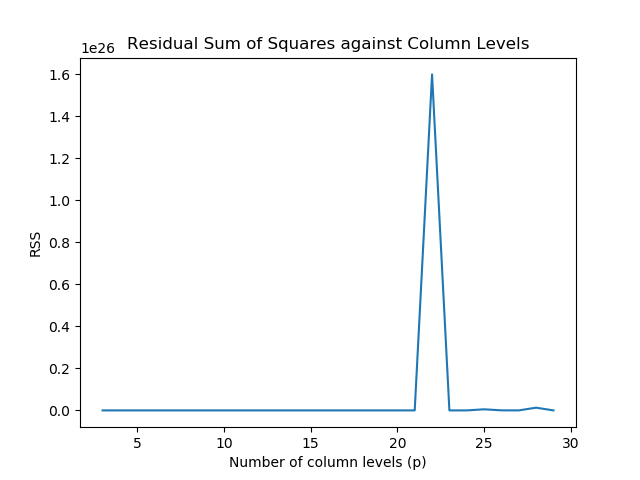

<IPython.core.display.Javascript object>


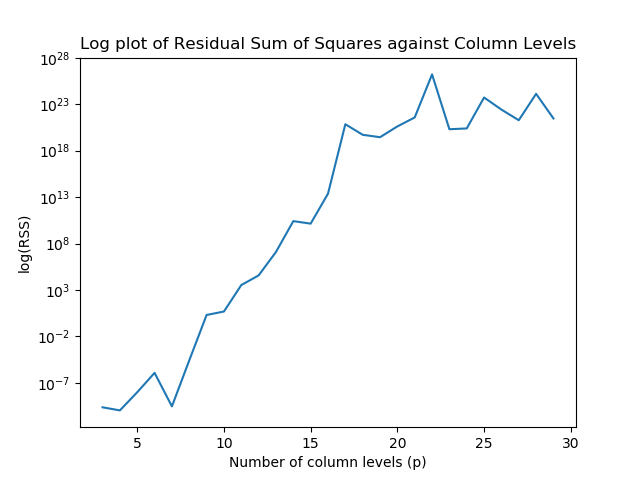

Text(0,0.5,'log(RSS)')

In [273]:
p_list = range(3,30)

# Bottom and top of plume
z_min = 0
z_max = 30000

# Parameters of mass ditribution in the plume
a = 3
b = 2

tot_mass = 1e10

q_dist = beta(a,b)

resses = np.zeros((len(p_list)))

for i, p in enumerate(p_list):
    inversion_table, sample_table, coefficient_matrix, input_table = run_sim(p, p, z_min, z_max, q_dist, s_sqr, tot_mass, sig)
    res_sqr = inversion_table["Residual"].values**2
    rss = sum(res_sqr)
    resses[i] = rss

plt.figure()
plt.plot(p_list, resses+1e-10)
plt.title("Residual Sum of Squares against Column Levels")
plt.xlabel("Number of column levels (p)")
plt.ylabel("RSS")

plt.figure()
plt.semilogy(p_list, resses+1e-10)
plt.title("Log plot of Residual Sum of Squares against Column Levels")
plt.xlabel("Number of column levels (p)")
plt.ylabel("log(RSS)")
# plt.colorbar()

## Test 2: Sample Spread

In this test, the spread of the sampling distribution is varied. 

This value is varied as a factor of the diffusion coefficient, within the range $[0.01 \times \sigma^2, 5 \times \sigma^2]$

<IPython.core.display.Javascript object>


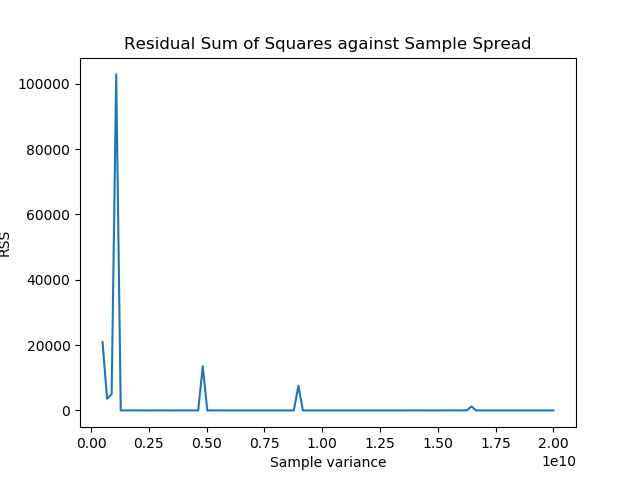

<IPython.core.display.Javascript object>


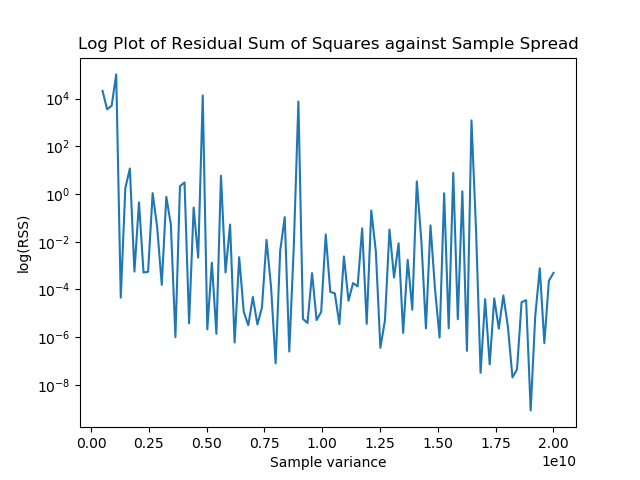

Text(0,0.5,'log(RSS)')

In [274]:
p=8
scales = np.linspace(0.5, 20, 100)
sig_list = scales*s_sqr
# Bottom and top of plume
z_min = 0
z_max = 30000

# Parameters of mass ditribution in the plume
a = 3
b = 2

tot_mass = 1e10

q_dist = beta(a,b)

resses = np.zeros((len(sig_list)))

for i, sig in enumerate(sig_list):
    inversion_table, sample_table, coefficient_matrix, input_table = run_sim(p, p, z_min, z_max, q_dist, s_sqr, tot_mass, sig)
    res_sqr = inversion_table["Residual"].values**2
    rss = sum(res_sqr)
    resses[i] = rss

plt.figure()
plt.plot(sig_list, resses+1e-10)
plt.title("Residual Sum of Squares against Sample Spread")
plt.xlabel("Sample variance")
plt.ylabel("RSS")

plt.figure()
plt.semilogy(sig_list, resses+1e-10)
plt.title("Log Plot of Residual Sum of Squares against Sample Spread")
plt.xlabel("Sample variance")
plt.ylabel("log(RSS)")

# plt.colorbar()

## Test 3: Varying both $p$ and the sample spread

Here, both variations above are combined.

<IPython.core.display.Javascript object>


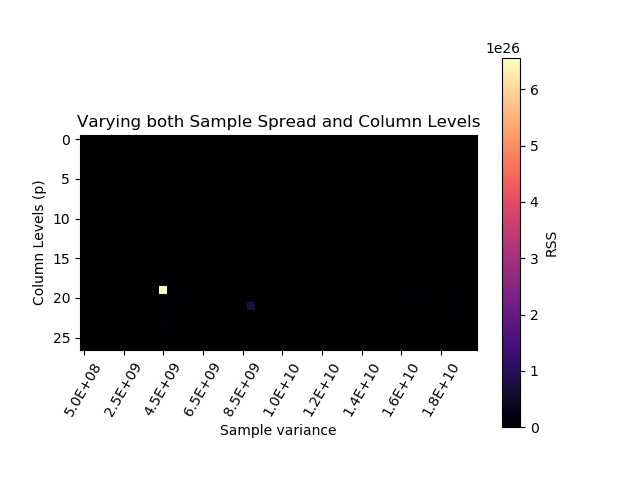

<IPython.core.display.Javascript object>


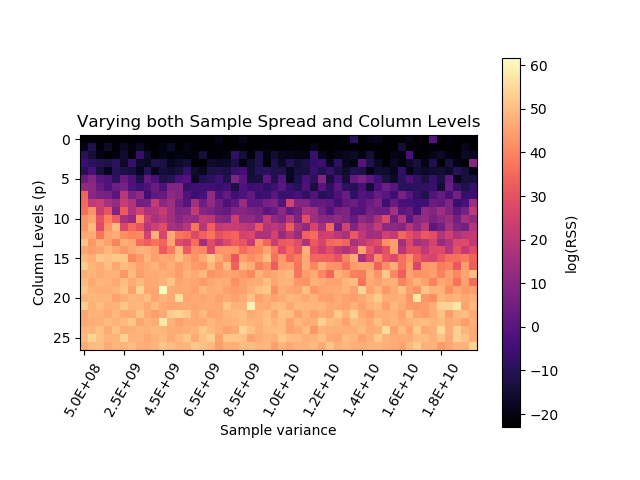

In [298]:
p_list = list(range(3,30))
scales = np.linspace(0.5, 20,50)
sig_list = scales*s_sqr

# Bottom and top of plume
z_min = 0
z_max = 30000

# Parameters of mass ditribution in the plume
a = 3
b = 2

tot_mass = 1e10

q_dist = beta(a,b)

resses = np.zeros((len(p_list), len(sig_list)))

for i, p in enumerate(p_list):
    for j, sig in enumerate(sig_list):
        inversion_table, sample_table, coefficient_matrix, input_table = run_sim(p, p, z_min, z_max, q_dist, s_sqr, tot_mass, sig)
        res_sqr = inversion_table["Residual"].values**2
        rss = sum(res_sqr)
        resses[i,j] = rss

plt.figure()
plt.imshow(resses+1e-10, cmap="magma")
plt.title("Varying both Sample Spread and Column Levels")
plt.xlabel("Sample variance")
plt.ylabel("Column Levels (p)")
cbar = plt.colorbar()
cbar.set_label("RSS")
locs = list(range(len(sig_list)))
locs = locs[::5]
labs = ['%.1E'%s for s in sig_list[::5]]
plt.xticks(locs, labs, rotation=60)
plt.show()

plt.figure()
plt.imshow(np.log(resses+1e-10), cmap="magma")
plt.title("Varying both Sample Spread and Column Levels")
plt.xlabel("Sample variance")
plt.ylabel("Column Levels (p)")
cbar = plt.colorbar()
cbar.set_label("log(RSS)")
locs = list(range(len(sig_list)))
locs = locs[::5]
labs = ['%.1E'%s for s in sig_list[::5]]
plt.xticks(locs, labs, rotation=60)
plt.show()